In [17]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings()

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)

doc_splits = text_splitter.split_documents(docs_list)

vectorStore = FAISS.from_documents(documents=doc_splits, embedding=OpenAIEmbeddings())

retriever = vectorStore.as_retriever()

In [19]:
#Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score:str=Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(model='gpt-4-turbo-2024-04-09')
structuredllm = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n
if the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.\n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)


retrieval_grader = grade_prompt | structuredllm
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question":question, "document":doc_txt}))

C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-4-turbo-2024-04-09 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


binary_score='no'


In [20]:
#Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model_name = "gpt-4-turbo-2024-04-09", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt |llm |StrOutputParser()

generation = rag_chain.invoke({"context":docs, "question":question})
print(generation)

In LLM-powered autonomous agent systems, memory is categorized into short-term and long-term types. Short-term memory involves in-context learning where the model utilizes immediate context to make decisions. Long-term memory allows the agent to retain and recall extensive information over prolonged periods, often using an external vector store for fast retrieval.


In [21]:
system = """You are a quesiton re-writer that converts an input question to a better version that is optimized \n
 for web search. Look at the input and try to reason about the underlying semantic intent/ meaning."""
rewritePrompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "here is the initial question: \n\n {question} \n Formulate an improved question."
        ),
    ]
)

question_rewriter = rewritePrompt | llm | StrOutputParser()
question_rewriter.invoke({"question":question})

'What is agent memory in artificial intelligence?'

In [22]:
###Search
from langchain_community.tools.tavily_search import TavilySearchResults
webSearchTool = TavilySearchResults(k=3)

In [23]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph
    
    Attributes:
        question: question
        generation: LLM Generation
        web_search: whether to add search
        documents: List of documents"""
    
    question:str
    generation:str
    web_search:str
    documents:List[str]

In [28]:
from langchain.schema import Document

def retrieve(state):
    """Retrieve documents
    Args:
        state(dict):The current graph state
        
    Returns:
        state(dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state['question']

    #Retrieval
    documents = retriever.invoke(question)
    return {'documents':documents, "question":question}

def generate(state):
    """Generate Answers
    
    Args:
        state(dict):The current state of the graph
        
    Returns:
        state(dict): New key added to the state, that contains LLM generation
    """
    print("---Generate---")
    question = state['question']
    documents = state['documents']

    #RAG generation
    generation = rag_chain.invoke({"context":documents, "question":question})
    return {"documents":documents, "question":question, "generation":generation}

def grade_document(state):
    """Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state(dict):The current graph state
        
    Returns:
        state(dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO Question---")
    question = state['question']
    documents = state['documents']

    #Score each doc
    filtered_docs = []
    web_search = "NO"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question":question, "document":d.page_content}
        )
        grade = score.binary_score
        if grade =="yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search="Yes"
            continue
    return {"documents":filtered_docs, "question":question, "web_search":web_search}


def transform_query(state):
    """Transform the query to produce a better question.
    Args:
        state(dict): The current graph state
    Returns:
        state(dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    #Re-write question 
    better_question = question_rewriter.invoke({"question":question})
    return {"documents":documents, "question":better_question}

def web_search(state):
    """Web Search based on the re-phrased question
    
    Args:
        state(dict):The current graph state
        
    Returns:
        state(dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH--")
    question = state["question"]
    documents = state["documents"]

    #Web Search
    docs = webSearchTool.invoke({"query":question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents":documents, "question":question}

def decide_to_generate(state):
    """Decide whether to generate an answer or regenerate a question
    
    Args: 
        state(dict): The current graph state
        
    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        #All documents have been filtered check_relevance
        #We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        #We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [29]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_document)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_document")
workflow.add_conditional_edges(
    "grade_document",
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate":"generate",
    },
)
workflow.add_edge("transform_query","web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()


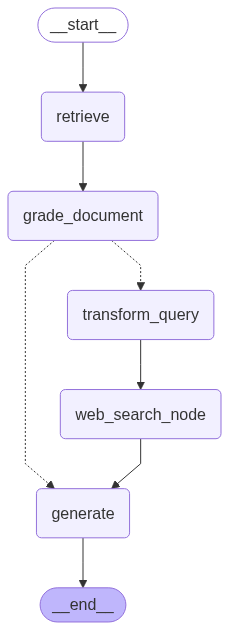

In [30]:
app

In [31]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO Question---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH--
---Generate---


{'question': 'What are the different types of memory used by agents in artificial intelligence?',
 'generation': 'In artificial intelligence, agents use several types of memory, including short-term memory, long-term memory, and episodic memory. Short-term memory allows agents to handle immediate interactions and maintain context within a single session. Long-term memory enables the retention and recall of information over extended periods, often supported by external storage like vector stores for fast retrieval, and includes semantic, episodic, and procedural elements to build a deeper knowledge foundation and adapt over time.',
 'web_search': 'Yes',
 'documents': [Document(id='0f30d336-4338-44c2-84cc-457fefdd1d4e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such 